# Homework 02: Multi-Class Classification with Neural Networks

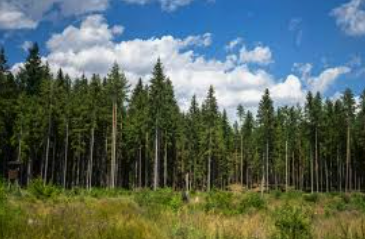

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [3]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2026-01-25 17:33:32.353506: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-25 17:33:33.961255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-25 17:33:36.761174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


$$k\cdot\sigma$$

In [10]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [6]:
# Your code here

X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=random_seed, stratify=y_sub)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from collections import Counter

print("Train class distribution:", Counter(y_train))
print("Test class distribution: ", Counter(y_test))

print("Train mean:", X_train_scaled.mean(axis=0)[:5])
print("Train std:", X_train_scaled.std(axis=0)[:5])

Train class distribution: Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Test class distribution:  Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})
Train mean: [-4.39773320e-16 -5.36899340e-17 -4.39960967e-17  8.00099620e-17
  2.54659165e-17]
Train std: [1. 1. 1. 1. 1.]


means = close enough to 0

std = 1

good!

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20


481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3342 - loss: 1.7620
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5554 - loss: 1.2881
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5949 - loss: 1.0321
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6274 - loss: 0.9302
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6504 - loss: 0.8765
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6625 - loss: 0.8418
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6724 - loss: 0.8161
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6806 - loss: 0.7952
Epoch 9/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6904 - loss: 0.7775
Epoch 10/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6965 - loss: 0.7618
Epoch 11/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7027 - loss: 0.7478
Epoch 12/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy

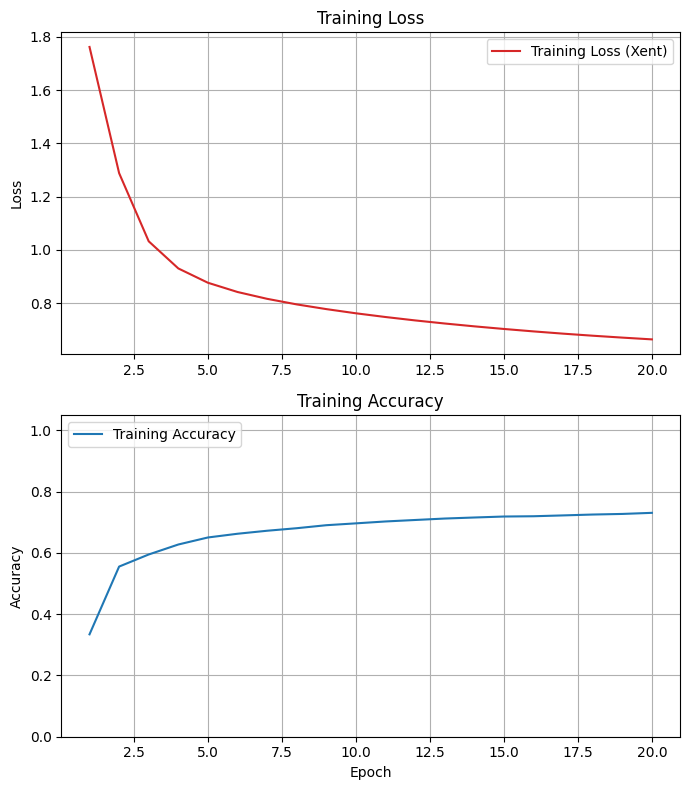

Final Training Loss:     0.6638
Final Training Accuracy: 0.7308


In [13]:
# Your code here

# build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    verbose=1
)

# plot training curves
plot_history(history)

In [14]:
# Set a1a to the final training accuracy at epoch 20

a1a = history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7308


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


===== training with batch size = 4 =====
Epoch 1/20


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3846/3846 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5390 - loss: 1.2663
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6583 - loss: 0.8603
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6824 - loss: 0.7828
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6986 - loss: 0.7401
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7102 - loss: 0.7098
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7185 - loss: 0.6856
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7253 - loss: 0.6656
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7314 - loss: 0.6484
Epoch 9/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7366 - loss: 0.6337
Epoch 10/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7412 - loss: 0.6210
Epoch 11/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7464 - loss: 0.6097
Epoch 12/20
3846/3846 ━━━━━━━━━━━━━━━━━━━

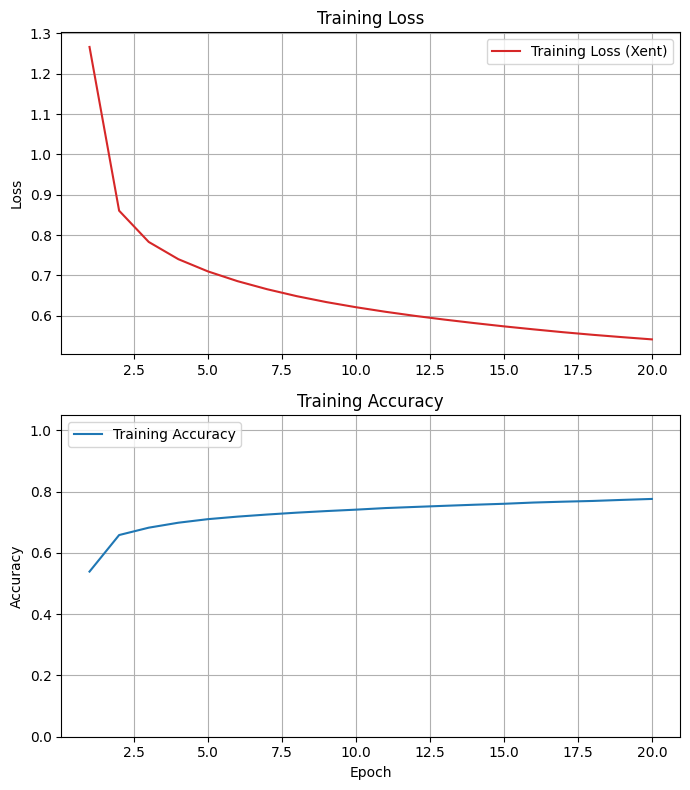

Final Training Loss:     0.5412
Final Training Accuracy: 0.7762

===== training with batch size = 8 =====
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4456 - loss: 1.5217
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6133 - loss: 0.9941
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6556 - loss: 0.8631
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6800 - loss: 0.8042
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6919 - loss: 0.7665
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7008 - loss: 0.7386
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7088 - loss: 0.7164
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7163 - loss: 0.6979
Epoch 9/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7226 - loss: 0.6819
Epoch 10/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7273 - loss: 0.6681
Epoch 11/20
1

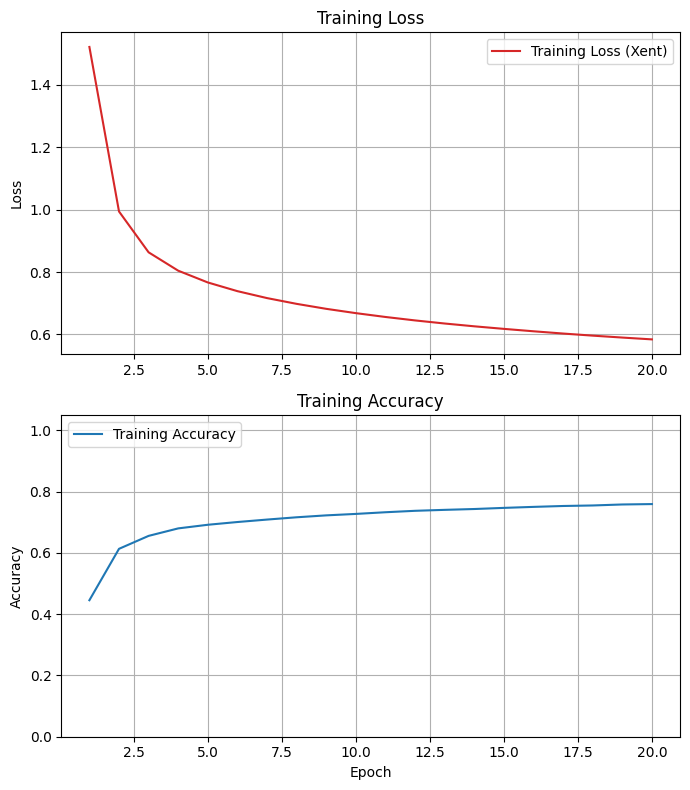

Final Training Loss:     0.5840
Final Training Accuracy: 0.7594

===== training with batch size = 16 =====
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3867 - loss: 1.6876
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5887 - loss: 1.1104
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6315 - loss: 0.9211
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6551 - loss: 0.8492
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6737 - loss: 0.8061
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6899 - loss: 0.7752
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7006 - loss: 0.7507
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7102 - loss: 0.7307
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7174 - loss: 0.7141
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7240 - loss: 0.7001
Epoch 11/20
962/962 ━━━━━━━━━━━━

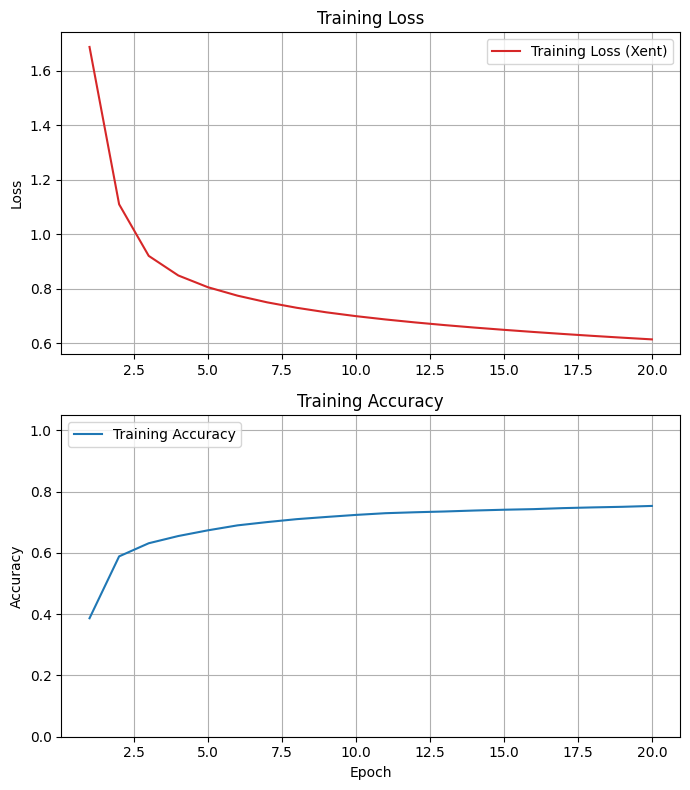

Final Training Loss:     0.6148
Final Training Accuracy: 0.7534

===== training with batch size = 128 =====
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1611 - loss: 1.9658
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3368 - loss: 1.7589
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5069 - loss: 1.5731
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5646 - loss: 1.4074
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5847 - loss: 1.2696
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5988 - loss: 1.1637
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6095 - loss: 1.0859
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6152 - loss: 1.0286
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 0.9855
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 0.9522
Epoch 11/20
121/121 ━━━━━━━━━━━

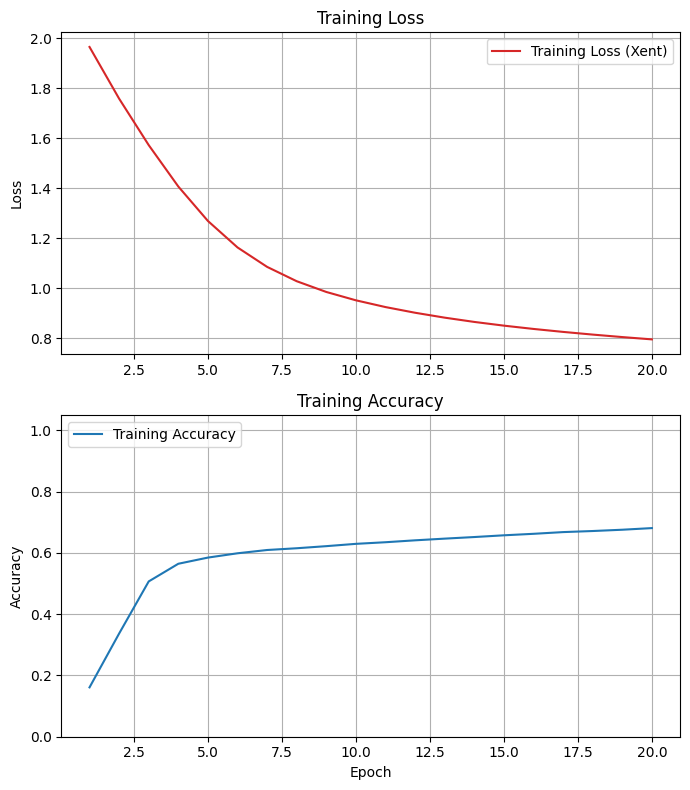

Final Training Loss:     0.7959
Final Training Accuracy: 0.6810


In [16]:
# Your code here

batch_sizes = [4, 8, 16, 128]
histories = {}
final_accuracies = {}

for bs in batch_sizes:
    print(f"\n===== training with batch size = {bs} =====")

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=20,
        batch_size=bs,
        verbose=1
    )

    plot_history(history)

    histories[bs] = history
    final_accuracies[bs] = history.history['accuracy'][-1]



In [17]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = max(final_accuracies, key=final_accuracies.get)             # Replace 0 with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [19]:
# Set a2b to the best accuracy score found

a2b = final_accuracies[a2a]             # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7762


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



===== training with learning rate = 0.001 =====


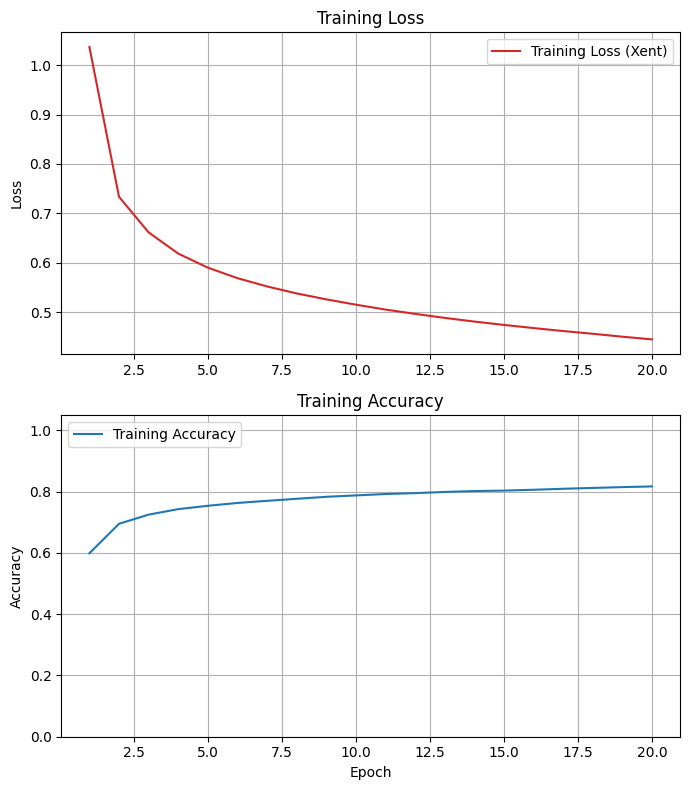

Final Training Loss:     0.4453
Final Training Accuracy: 0.8170

===== training with learning rate = 0.0005 =====


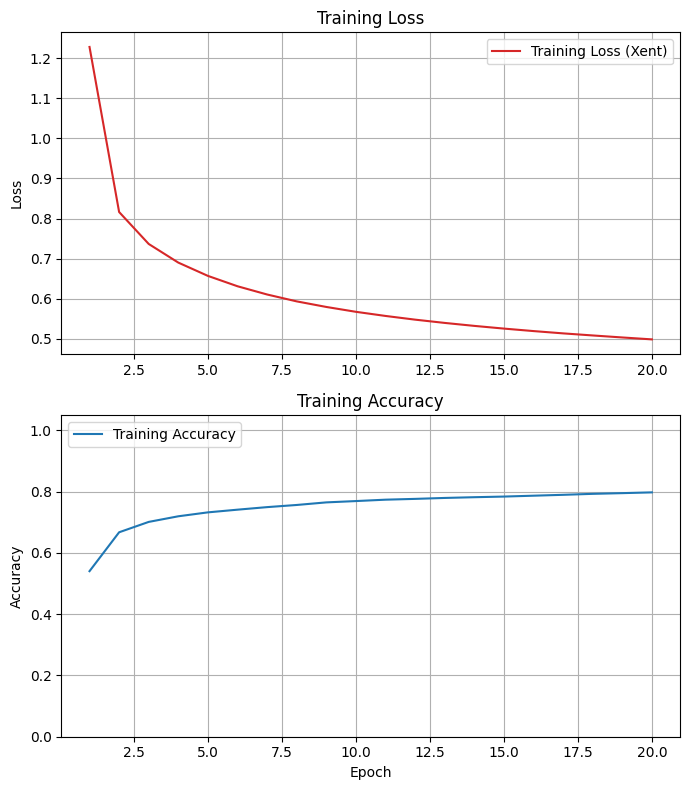

Final Training Loss:     0.4982
Final Training Accuracy: 0.7976

===== training with learning rate = 0.0001 =====


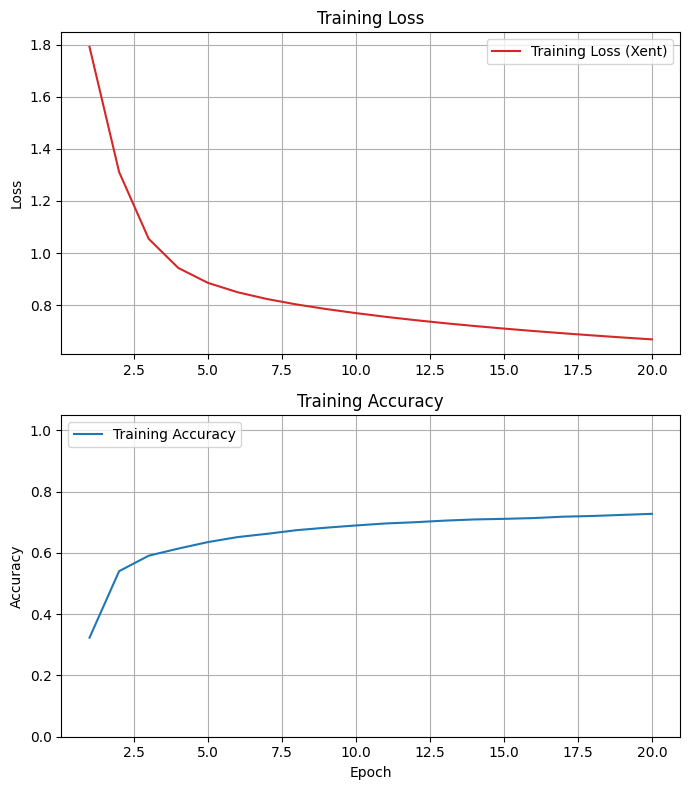

Final Training Loss:     0.6688
Final Training Accuracy: 0.7276

===== training with learning rate = 5e-05 =====


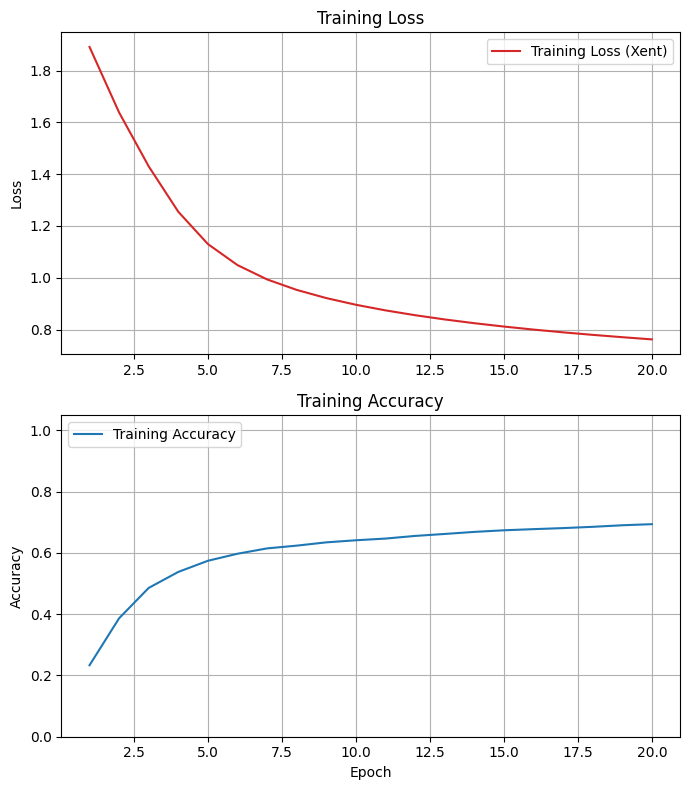

Final Training Loss:     0.7619
Final Training Accuracy: 0.6938

===== training with learning rate = 1e-05 =====


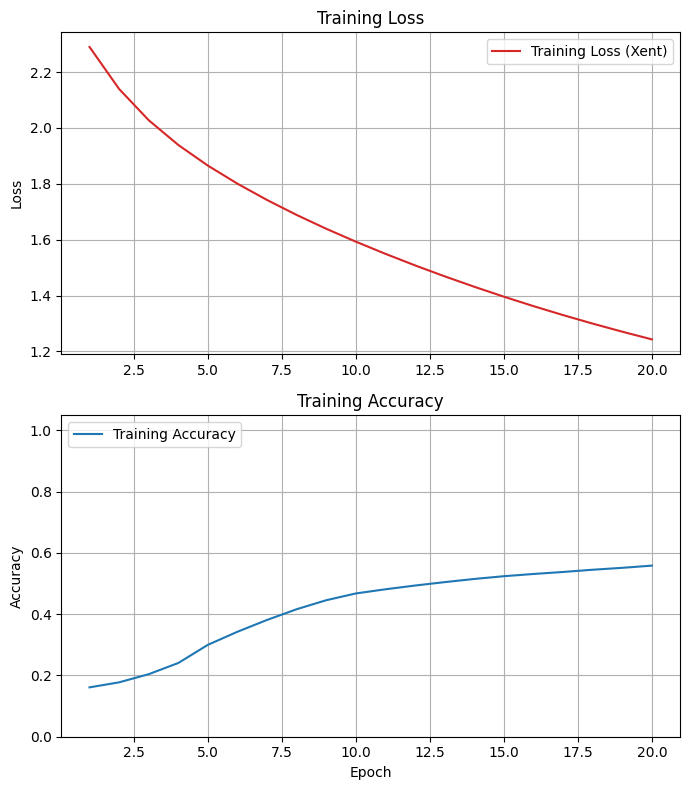

Final Training Loss:     1.2429
Final Training Accuracy: 0.5585


In [21]:
# Your code here

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
histories_lr = {}
final_accuracies_lr = {}

for lr in learning_rates:
    print(f"\n===== training with learning rate = {lr} =====")

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=20,
        batch_size=32,
        verbose=0
    )

    plot_history(history)

    histories_lr[lr] = history
    final_accuracies_lr[lr] = history.history['accuracy'][-1]


In [22]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = max(final_accuracies_lr, key=final_accuracies_lr.get)             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [24]:
# Set a3b to the accuracy found by the best learning rate

a3b = final_accuracies_lr[a3a]             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8170


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


===== Training with CosineDecay, initial lr = 0.01 =====


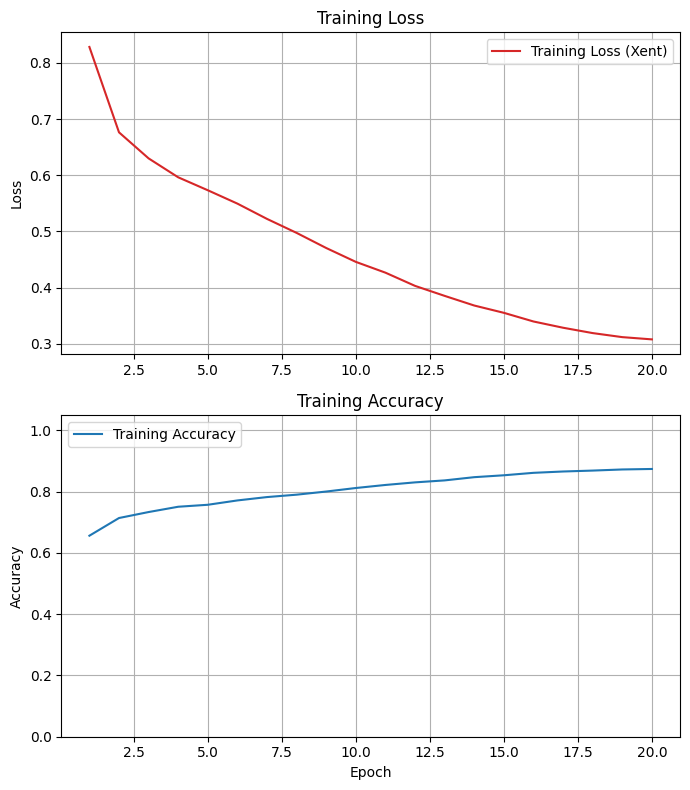

Final Training Loss:     0.3079
Final Training Accuracy: 0.8740

===== Training with CosineDecay, initial lr = 0.005 =====


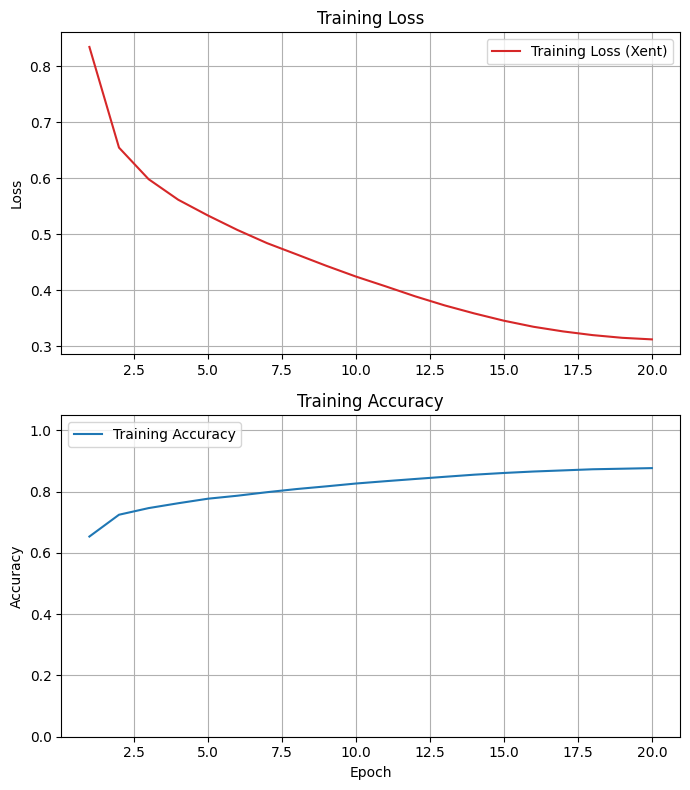

Final Training Loss:     0.3122
Final Training Accuracy: 0.8768

===== Training with CosineDecay, initial lr = 0.001 =====


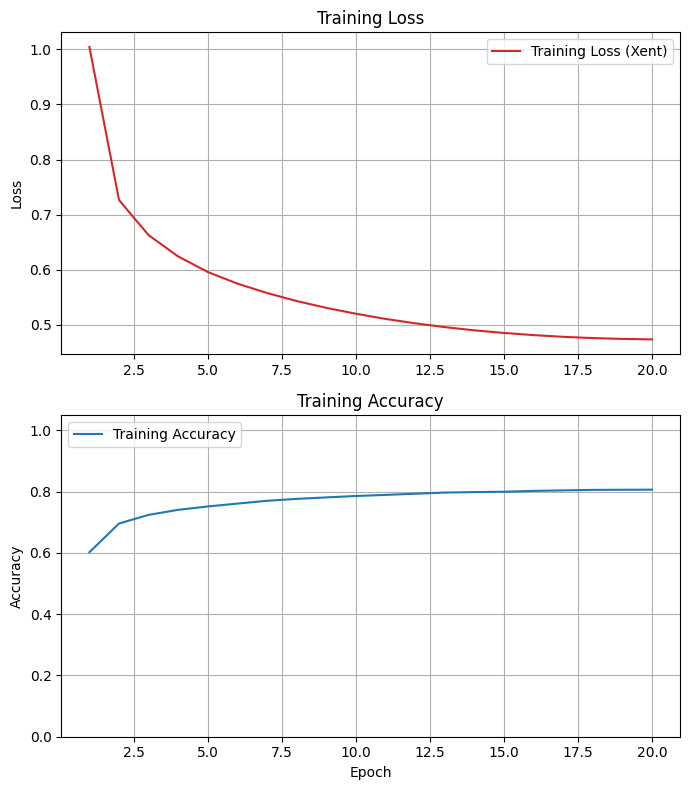

Final Training Loss:     0.4737
Final Training Accuracy: 0.8065

===== Training with CosineDecay, initial lr = 0.0005 =====


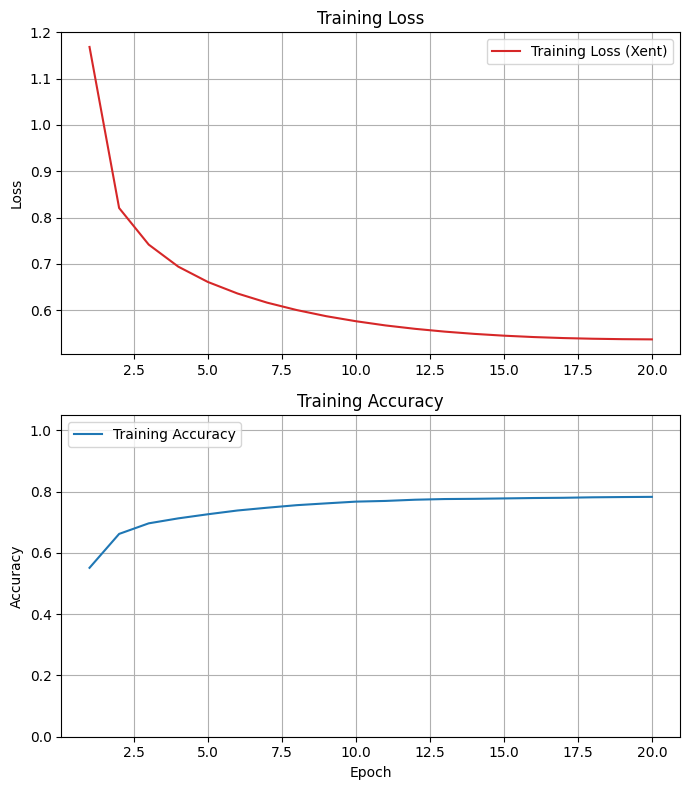

Final Training Loss:     0.5368
Final Training Accuracy: 0.7829

===== Training with CosineDecay, initial lr = 0.0001 =====


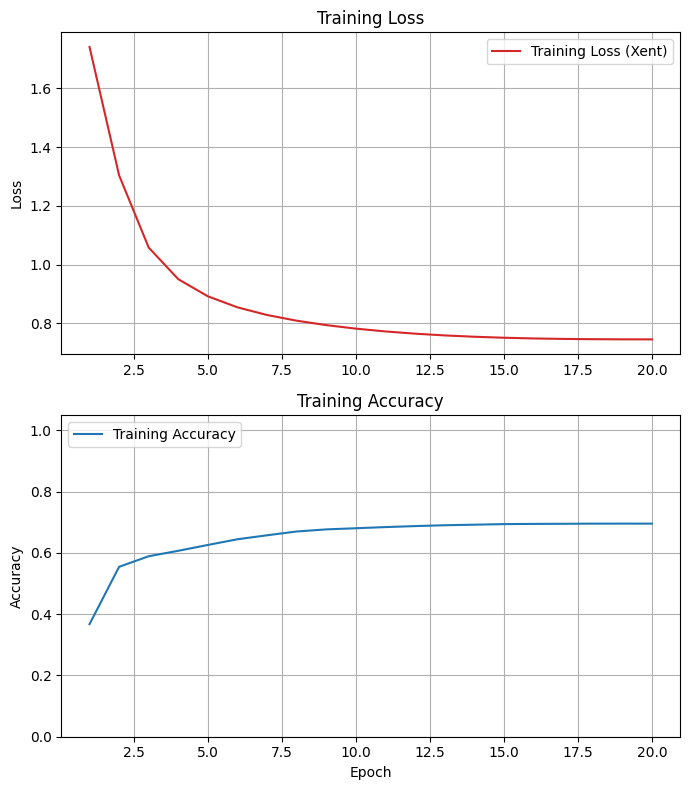

Final Training Loss:     0.7454
Final Training Accuracy: 0.6956


In [26]:
# Your code here

initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
histories_cd = {}
final_accuracies_cd = {}

steps_per_epoch = int(np.ceil(len(X_train_scaled) / 32))
decay_steps = steps_per_epoch * 20   # total steps over 20 epochs

for lr in initial_learning_rates:
    print(f"\n===== Training with CosineDecay, initial lr = {lr} =====")

    lr_schedule = CosineDecay(
        initial_learning_rate=lr,
        decay_steps=decay_steps,
        alpha=0.0
    )

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train_scaled,
        y_train,
        epochs=20,
        batch_size=32,
        verbose=0
    )

    plot_history(history)

    histories_cd[lr] = history
    final_accuracies_cd[lr] = history.history['accuracy'][-1]


In [27]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = max(final_accuracies_cd, key=final_accuracies_cd.get)             # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0050


In [29]:
# Set a4b to the best accuracy found

a4b = final_accuracies_cd[a4a]             # Replace 0.0 with your answer

In [30]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8768


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

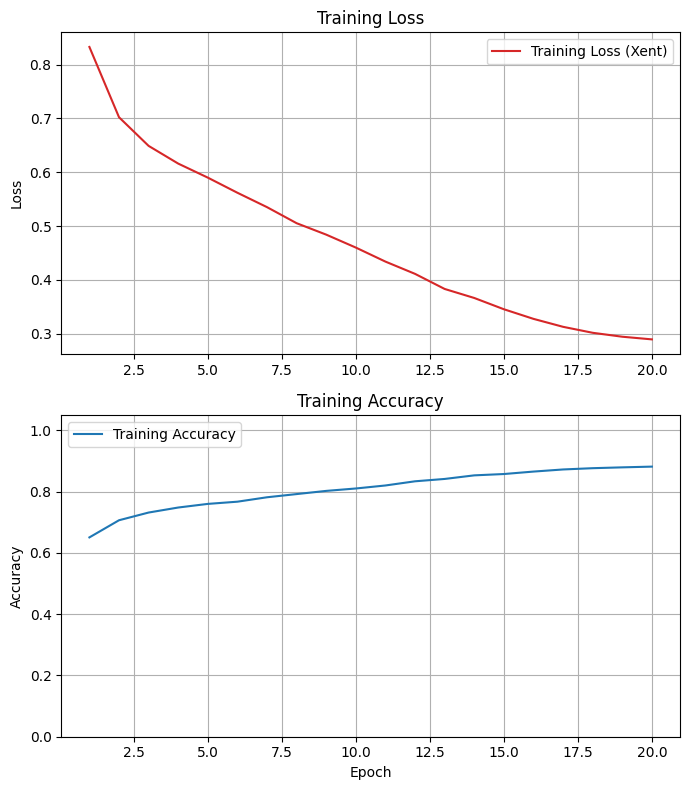

Final Training Loss:     0.2897
Final Training Accuracy: 0.8817


In [31]:
# Your code here -- add as many cells as you need

# best hyperparameters found
best_batch_size = 4
best_initial_lr = 5e-3

steps_per_epoch = int(np.ceil(len(X_train_scaled) / best_batch_size))
decay_steps = steps_per_epoch * 20

lr_schedule = CosineDecay(
    initial_learning_rate=best_initial_lr,
    decay_steps=decay_steps,
    alpha=0.0
)

# build model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# compile model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# train model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=best_batch_size,
    verbose=0
)

# plot training curves
plot_history(history)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)


In [32]:
# Set a5a to the best training accuracy found by your best model

a5a = history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8817


In [34]:
# Set a5b to the test accuracy found by your best model

a5b = test_accuracy             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8341


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


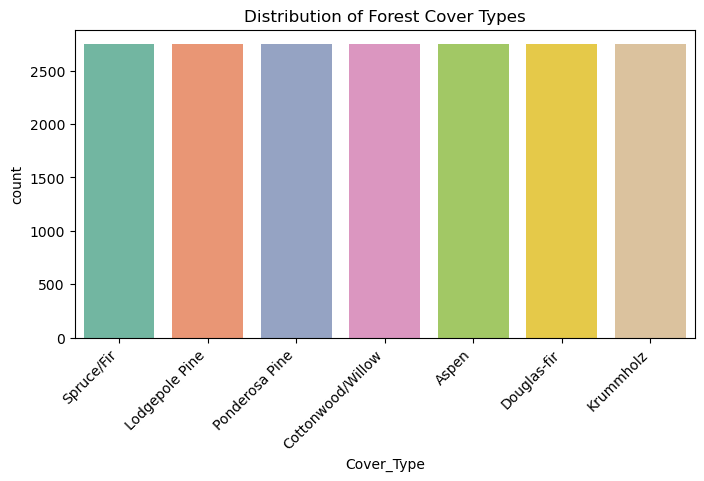

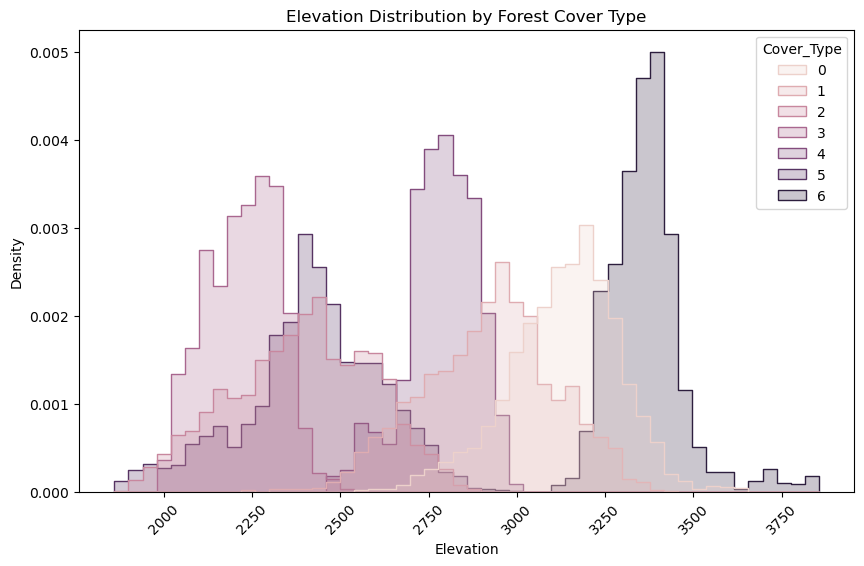

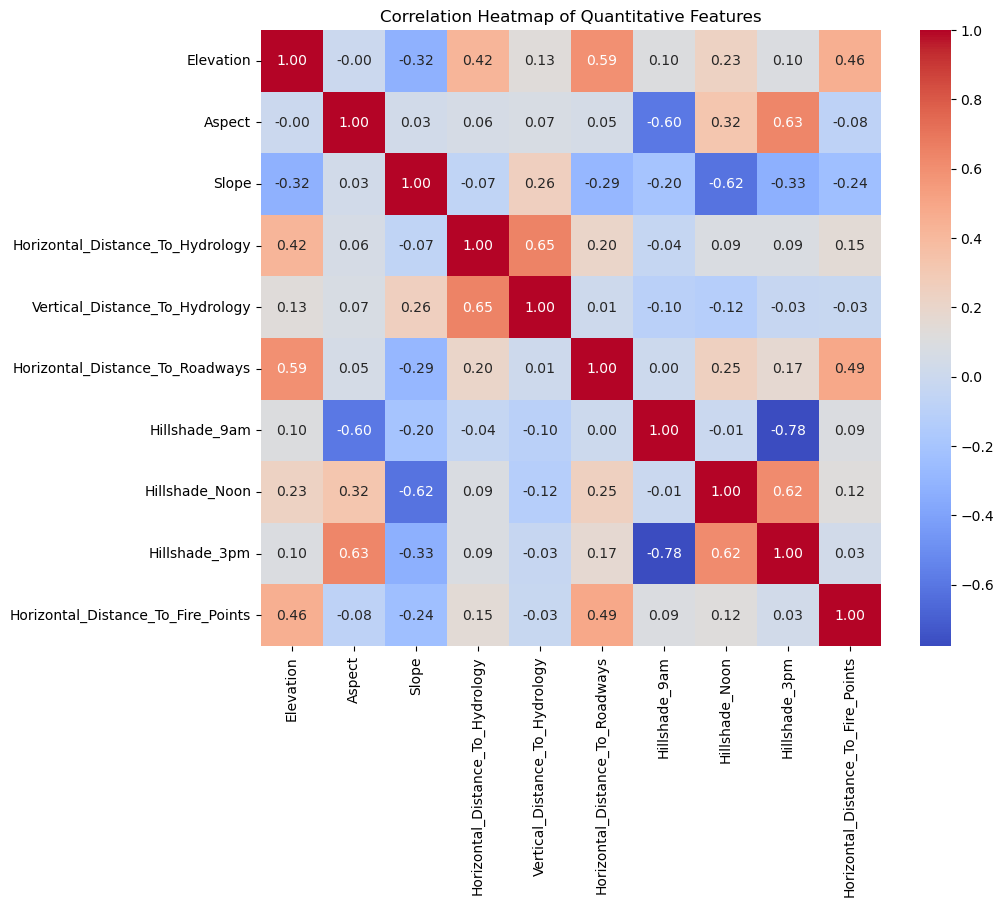

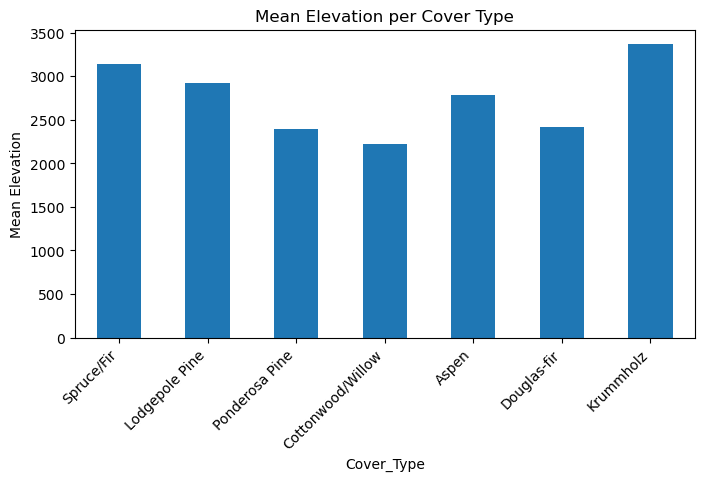

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
